# Analyze a Target Forecast

* **About 10 mins may be elapsed**

In [1]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

In [2]:
# 다른 노트북에서 저장된 변수들을 불러옴
%store -r
# target_prophet_predictorArn
# target_deepar_predictorArn


In [3]:
session = boto3.Session(region_name=region)
forecast = session.client(service_name='forecast')
forecast_query = session.client(service_name='forecastquery')

## Obtaining the forecast results from S3

In [62]:
import os
prophet_result_dir = "prophet" + suffix
deepar_result_dir = "deeparp" + suffix
! mkdir -p {prophet_result_dir} # Create a folder for prophet forecast result
! mkdir -p {deepar_result_dir}

In [63]:
# Prophet
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
prefix = bucket_folder + "/" +  "prophet_" + target_suffix + suffix
prophet_filename = ""
# print("prefix: ", prefix)
prophet_files = list(poc_bucket.objects.filter(Prefix=prefix))
# print("prophet_files: ", prophet_files)
for file in prophet_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        prophet_filename = file.key.split('/')[2]
        s3.Bucket(bucket_name).download_file(file.key, prophet_result_dir+"/"+prophet_filename)


In [64]:
# DeepAR+
s3 = boto3.resource('s3')
poc_bucket = boto3.resource('s3').Bucket(bucket_name)
prefix = bucket_folder + "/" + "deeparp_" + target_suffix + suffix
deeparp_filename = ""
deeparp_files = list(poc_bucket.objects.filter(Prefix=prefix))
# print(deeparp_files)
# print(deeparp_files)
for file in deeparp_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        deeparp_filename = file.key.split('/')[2]
        s3.Bucket(bucket_name).download_file(file.key, deepar_result_dir+"/"+deeparp_filename)
# print(deeparp_filename)

In [65]:
def getTotalForecastResult(resultFolder):
    """
    Return a dataframe containing all forecast files in the folder passed
    """
    total_predicts_s3 = pd.DataFrame()
    for file in os.listdir(resultFolder):
        predicts_s3 = pd.read_csv(resultFolder + "/" + file)
        total_predicts_s3 = total_predicts_s3.append(predicts_s3)
    return total_predicts_s3
    
prophet_predicts_s3 = getTotalForecastResult(prophet_result_dir)    
deeparp_predicts_s3 = getTotalForecastResult(deepar_result_dir)    


In [66]:
# Remove the folders already used
! rm -rf {prophet_result_dir}
! rm -rf {deepar_result_dir}

## Load forecast results from local folder 

In [67]:
prophet_predicts_s3.info()
deeparp_predicts_s3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15500 entries, 0 to 15499
Data columns (total 6 columns):
item_id    15500 non-null int64
date       15500 non-null object
store      15500 non-null int64
p10        15500 non-null float64
p50        15500 non-null float64
p90        15500 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 726.6+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15500 entries, 0 to 1146
Data columns (total 6 columns):
item_id    15500 non-null int64
date       15500 non-null object
store      15500 non-null int64
p10        15500 non-null float64
p50        15500 non-null float64
p90        15500 non-null float64
dtypes: float64(3), int64(2), object(1)
memory usage: 847.7+ KB


In [68]:
prophet_predicts = prophet_predicts_s3.copy()
prophet_predicts.head()


,item_id,date,store,p10,p50,p90
0,1,2017-12-01T00:00:00Z,2,24.081731,32.472395,37.873244
1,1,2017-12-02T00:00:00Z,2,26.269695,32.436963,39.063538
2,1,2017-12-03T00:00:00Z,2,25.467644,32.597969,40.298139
3,1,2017-12-04T00:00:00Z,2,15.512930,22.634771,28.245821
4,1,2017-12-05T00:00:00Z,2,16.940243,23.277911,30.937636


In [69]:
# Remove the timezone
prophet_predicts = prophet_predicts_s3.copy()
prophet_predicts['date'] = pd.to_datetime(prophet_predicts['date']) # + pd.DateOffset(days=4)
prophet_predicts['date'] = prophet_predicts['date'].dt.tz_convert(None) # Convert time zone
prophet_predicts.date = pd.to_datetime(prophet_predicts.date, format= '%Y-%m-%d') # Change a format of yyyy-mm-dd
prophet_predicts.item_id = prophet_predicts.item_id.astype(str) # convert to string type
prophet_predicts.store = prophet_predicts.store.astype(str) # convert to string type
prophet_predicts = prophet_predicts[['date','item_id','store','p10', 'p50', 'p90']]

prophet_predicts.head()

,date,item_id,store,p10,p50,p90
0,2017-12-01,1,2,24.081731,32.472395,37.873244
1,2017-12-02,1,2,26.269695,32.436963,39.063538
2,2017-12-03,1,2,25.467644,32.597969,40.298139
3,2017-12-04,1,2,15.512930,22.634771,28.245821
4,2017-12-05,1,2,16.940243,23.277911,30.937636


In [70]:
# Remove the timezone
deeparp_predicts = deeparp_predicts_s3.copy()
deeparp_predicts['date'] = pd.to_datetime(deeparp_predicts['date']) # + pd.DateOffset(days=4)
deeparp_predicts['date'] = deeparp_predicts['date'].dt.tz_convert(None) # Convert time zone
deeparp_predicts.date = pd.to_datetime(deeparp_predicts.date, format= '%Y-%m-%d') # Change a format of yyyy-mm-dd
deeparp_predicts.item_id = deeparp_predicts.item_id.astype(str) # convert to string type
deeparp_predicts.store = deeparp_predicts.store.astype(str) # convert to string type
deeparp_predicts = deeparp_predicts[['date','item_id','store','p10', 'p50', 'p90']]
# deeparp_predicts = deeparp_predicts[deeparp_predicts.item_id == "1"] # only for itme_id == 1
deeparp_predicts.head()
# prophet_predicts.dtypes

,date,item_id,store,p10,p50,p90
0,2017-12-01,35,2,75.321159,86.689850,101.114784
1,2017-12-02,35,2,79.343925,89.757912,104.891380
2,2017-12-03,35,2,80.297607,92.429054,104.758598
3,2017-12-04,35,2,48.497337,57.735744,68.805489
4,2017-12-05,35,2,57.604900,68.300331,77.809372


## Prepare validation file

In [71]:
validation_df = validation_stores_sales.copy()
validation_df.reset_index(inplace=True) # reset index
validation_df = validation_df.rename(columns={'index':'date'}) # Change column name to date
validation_df.date = pd.to_datetime(validation_df.date, format= '%Y-%m-%d') # Change a format of yyyy-mm-dd
validation_df.head()
# validation_df.dtypes


,date,item_id,store,sales
0,2017-12-01,1,1,19
1,2017-12-02,1,1,16
2,2017-12-03,1,1,31
3,2017-12-04,1,1,7
4,2017-12-05,1,1,20


## Join forecast results with validation data

In [72]:
# Prophet
prophet_val_df = pd.merge(prophet_predicts,validation_df, 
                          on=['date', 'item_id','store'], 
                          how='inner')
                          
prophet_val_df.set_index('date', inplace=True)
prophet_val_df.head(10)

,item_id,store,p10,p50,p90,sales
date,,,,,,
2017-12-01,1,2,24.081731,32.472395,37.873244,31
2017-12-02,1,2,26.269695,32.436963,39.063538,24
2017-12-03,1,2,25.467644,32.597969,40.298139,20
2017-12-04,1,2,15.512930,22.634771,28.245821,10
2017-12-05,1,2,16.940243,23.277911,30.937636,14
2017-12-06,1,2,15.520981,22.113174,28.453155,12
2017-12-07,1,2,19.215778,25.116472,32.205941,21
2017-12-08,1,2,22.377947,28.464991,34.784285,27
2017-12-09,1,2,22.351122,29.322866,36.878653,29


In [73]:
# deeparp
deeparp_val_df = pd.merge(deeparp_predicts,validation_df, 
                          on=['date', 'item_id','store'], 
                          how='inner')
                          
deeparp_val_df.set_index('date', inplace=True)
deeparp_val_df.head(10)
# deeparp_val_df[deeparp_val_df.item_id == "1"].head()

,item_id,store,p10,p50,p90,sales
date,,,,,,
2017-12-01,35,2,75.321159,86.689850,101.114784,77
2017-12-02,35,2,79.343925,89.757912,104.891380,77
2017-12-03,35,2,80.297607,92.429054,104.758598,84
2017-12-04,35,2,48.497337,57.735744,68.805489,61
2017-12-05,35,2,57.604900,68.300331,77.809372,53
2017-12-06,35,2,57.087635,67.056633,80.252686,55
2017-12-07,35,2,62.073410,73.431549,84.324661,75
2017-12-08,35,2,65.396210,75.532318,86.788193,67
2017-12-09,35,2,69.696838,82.350861,91.878555,87


## MAPE metric for Prophet and DeepARP

In [74]:
prophet_val_metric_df = prophet_val_df.copy()
n_rows = prophet_val_metric_df.shape[0]
prophet_val_metric_df['mape_p50'] = (abs(prophet_val_metric_df.sales - prophet_val_metric_df.p50) / prophet_val_metric_df.sales ) 
# prophet_val_metric_df.head(200)
print("prophet MAPE: ", prophet_val_metric_df['mape_p50'].mean())
prophet_val_metric_df.head(4)


prophet MAPE:  0.1705254834693979


,item_id,store,p10,p50,p90,sales,mape_p50
date,,,,,,,
2017-12-01,1,2,24.081731,32.472395,37.873244,31,0.047497
2017-12-02,1,2,26.269695,32.436963,39.063538,24,0.351540
2017-12-03,1,2,25.467644,32.597969,40.298139,20,0.629898
2017-12-04,1,2,15.512930,22.634771,28.245821,10,1.263477


In [75]:
deeparp_val_metric_df = deeparp_val_df.copy()
n_rows = deeparp_val_metric_df.shape[0]
deeparp_val_metric_df['mape_p50'] = (abs(deeparp_val_metric_df.sales - deeparp_val_metric_df.p50) / deeparp_val_metric_df.sales ) 
# prophet_val_metric_df.head(200)
print("deeparp: ", deeparp_val_metric_df['mape_p50'].mean())
deeparp_val_metric_df.head(4)

deeparp:  0.1520874286262197


,item_id,store,p10,p50,p90,sales,mape_p50
date,,,,,,,
2017-12-01,35,2,75.321159,86.689850,101.114784,77,0.125842
2017-12-02,35,2,79.343925,89.757912,104.891380,77,0.165687
2017-12-03,35,2,80.297607,92.429054,104.758598,84,0.100346
2017-12-04,35,2,48.497337,57.735744,68.805489,61,0.053512


## An example of single forecast with Item_id and Store

In [76]:
forecast_query_response = forecast_query.query_forecast(
    ForecastArn = target_prophet_forecast_arn,
    StartDate = "2017-12-29T00:00:00",
    EndDate = "2017-12-31T00:00:00",
    Filters={"item_id": "1", "store":"1"}
)
forecast_query_response

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2017-12-29T00:00:00',
     'Value': 12.591022491455078},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 13.538614273071289},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 13.60527229309082}],
   'p50': [{'Timestamp': '2017-12-29T00:00:00', 'Value': 17.939306259155273},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 20.60787010192871},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 19.855192184448242}],
   'p90': [{'Timestamp': '2017-12-29T00:00:00', 'Value': 24.104650497436523},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 25.87094497680664},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 26.05683135986328}]}},
 'ResponseMetadata': {'RequestId': '41b0238d-5e53-402f-b995-bcd2735ef8aa',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 04 Apr 2020 13:04:03 GMT',
   'x-amzn-requestid': '41b0238d-5e53-402f-b995-bcd2735ef8aa',
   'content-length': '617',
   'conn

## An example of single forecast with Item_id

In [77]:

forecast_query_response = forecast_query.query_forecast(
    ForecastArn = target_prophet_forecast_arn,
    StartDate = "2017-12-29T00:00:00",
    EndDate = "2017-12-31T00:00:00",
    Filters={"item_id":"1"}
)

forecast_query_response

{'Forecast': {'Predictions': {'p10': [{'Timestamp': '2017-12-29T00:00:00',
     'Value': 140.46814727783203},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 158.8834352493286},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 172.2816162109375}],
   'p50': [{'Timestamp': '2017-12-29T00:00:00', 'Value': 204.8759527206421},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 221.61196517944336},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 233.30370330810547}],
   'p90': [{'Timestamp': '2017-12-29T00:00:00', 'Value': 264.7873115539551},
    {'Timestamp': '2017-12-30T00:00:00', 'Value': 281.05544662475586},
    {'Timestamp': '2017-12-31T00:00:00', 'Value': 293.47859954833984}]}},
 'ResponseMetadata': {'RequestId': '37191415-108b-4653-8aef-4d9de8a69e64',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 04 Apr 2020 13:04:04 GMT',
   'x-amzn-requestid': '37191415-108b-4653-8aef-4d9de8a69e64',
   'content-length': '617',
   'conn

## Analyse prophet and deepar+ for some stores

In [78]:
from utils import show_two_chart_horizontal

In [79]:
deeparp_val_df.item_id.unique()
# prophet_val_df.item_id.unique()
deeparp_val_df.store.unique()

array(['2', '4', '1', '8', '10', '6', '7', '5', '9', '3'], dtype=object)

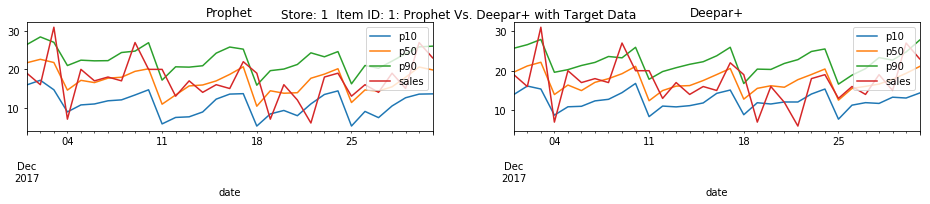

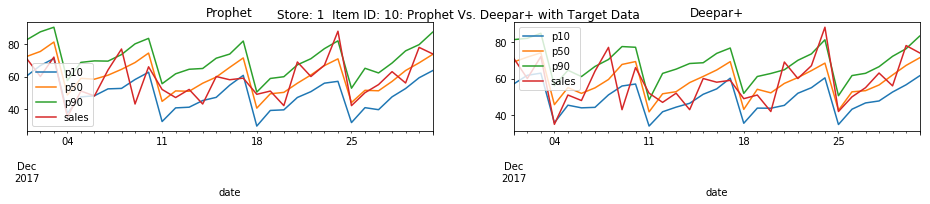

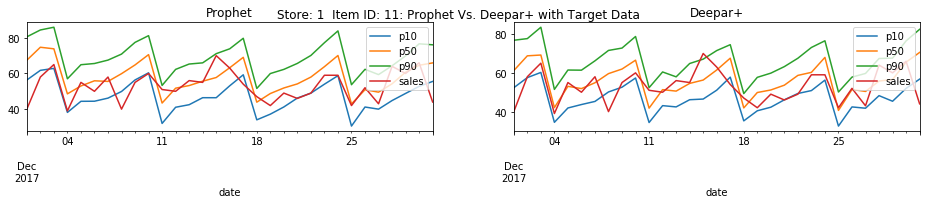

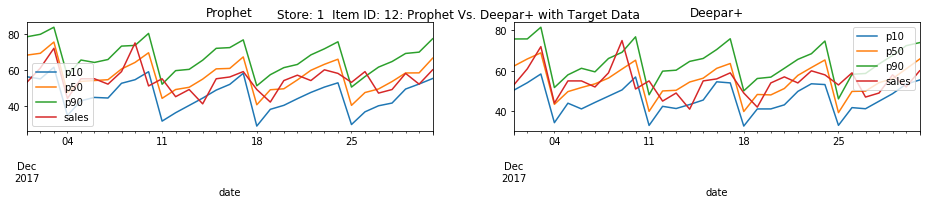

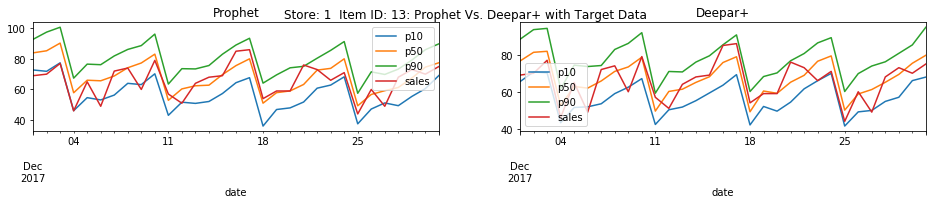

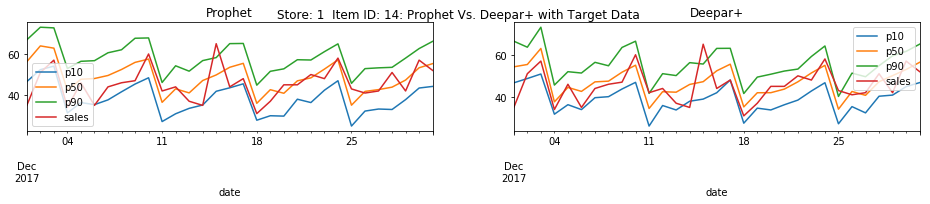

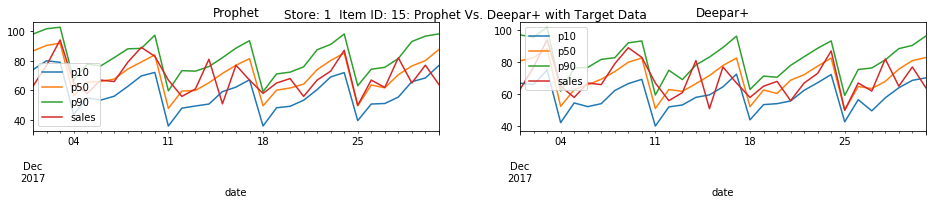

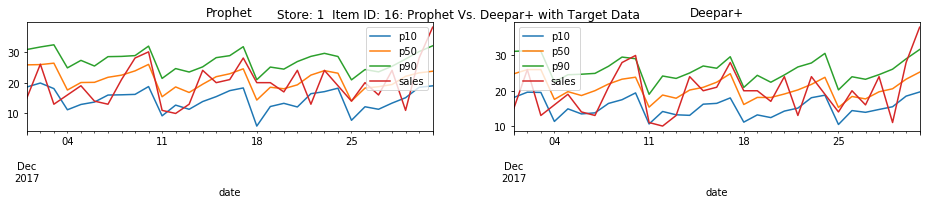

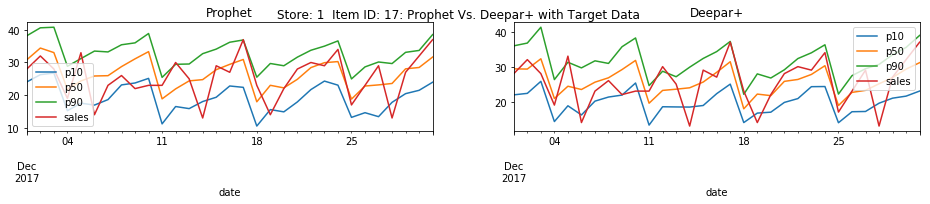

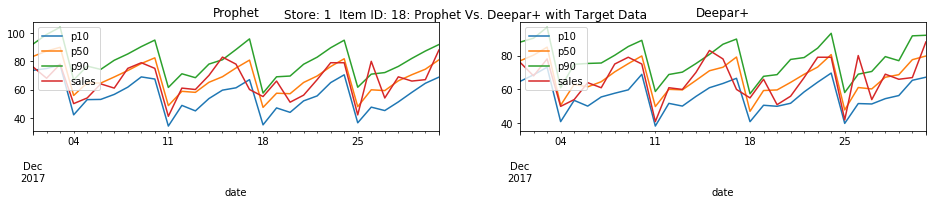

In [80]:
store_item_df = pd.DataFrame(deeparp_val_df.groupby(['store','item_id']).count())
store_item_df = store_item_df.reset_index()


display_num = 10
for i, rows in store_item_df.iterrows():
    store_id = rows['store']
    item_id = rows['item_id']    
    if display_num == i:
        break
    filter_prophet = (prophet_val_df.item_id == str(item_id)) & (prophet_val_df.store == str(store_id))
    filter_deeparp = (deeparp_val_df.item_id == str(item_id)) & (deeparp_val_df.store == str(store_id))
    
    prophet_val_single_df = prophet_val_df[filter_prophet]
    deeparp_val_single_df = deeparp_val_df[filter_deeparp]    
    plot_title = "Store: " + str(store_id) + "  Item ID: " + str(item_id) + ": Prophet Vs. Deepar+ with Target Data"
    show_two_chart_horizontal(plot_title, 
                          prophet_val_single_df, 
                          "Prophet", 
                          deeparp_val_single_df,
                          "Deepar+", 
                         )
        